In [1]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

from datetime import datetime
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
import pandas as pd
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pmdarima as pm
from pmdarima.arima import ADFTest
from dateutil.relativedelta import relativedelta, MO
import matplotlib.dates as mdates
import seaborn as sns
import joblib
import sys
import time
from tensorflow.python.keras import backend as K

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [3]:
dataset = pd.read_csv("Compiegne.csv", skiprows=10, skipfooter=10, engine='python')
df_Compiegne = pd.DataFrame(dataset)

df_Compiegne['time'] = pd.to_datetime(df_Compiegne['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_Compiegne = df_Compiegne.set_index(['time'])

print(df_Compiegne.head())

                       P  G(i)  H_sun   T2m  WS10m  Int
time                                                   
2021-01-01 00:10:00  0.0   0.0    0.0 -0.21   1.59  0.0
2021-01-01 01:10:00  0.0   0.0    0.0 -0.44   1.59  0.0
2021-01-01 02:10:00  0.0   0.0    0.0 -0.48   1.38  0.0
2021-01-01 03:10:00  0.0   0.0    0.0 -0.47   1.24  0.0
2021-01-01 04:10:00  0.0   0.0    0.0 -0.50   1.24  0.0


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_26048\2747761436.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_Compiegne['time'] = pd.to_datetime(df_Compiegne['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)


In [4]:
df_Compiegne_Temp = df_Compiegne.iloc[:, [3]]

print(df_Compiegne_Temp.head())

                      T2m
time                     
2021-01-01 00:10:00 -0.21
2021-01-01 01:10:00 -0.44
2021-01-01 02:10:00 -0.48
2021-01-01 03:10:00 -0.47
2021-01-01 04:10:00 -0.50


In [5]:
df_jan_feb_2021 = df_Compiegne_Temp.loc['2021-01-01':'2021-02-28']
df_march_2021 = df_Compiegne_Temp.loc['2021-03-01':'2021-03-31']

In [6]:
print(df_jan_feb_2021.tail())

                      T2m
time                     
2021-02-28 19:10:00  6.85
2021-02-28 20:10:00  5.93
2021-02-28 21:10:00  5.20
2021-02-28 22:10:00  4.62
2021-02-28 23:10:00  4.13


In [7]:
print(df_march_2021.tail())

                       T2m
time                      
2021-03-31 19:10:00  16.75
2021-03-31 20:10:00  13.99
2021-03-31 21:10:00  12.00
2021-03-31 22:10:00  10.58
2021-03-31 23:10:00   9.90


# Training the Model (LSTM)

In [8]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0]) # Whichever feature needs to be predicted
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [9]:
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	# data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]

	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [10]:
def reframe_datasets(training, testing, n_input):

	# restructure into windows of hourly data
	train = array(np.split(training, len(training)/n_input))
	test = array(np.split(testing, len(testing)/n_input))

	return train, test

In [11]:
# train the model
def build_model(train, n_input, n_output):
	# prepare data
	train_x, train_y = to_supervised(train, n_input, n_output)

	# define parameters
	verbose, epochs, batch_size = 2, 100, 1
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(32, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(32, activation='relu', return_sequences=True))
	# model.add(TimeDistributed(Dense(16, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [12]:
# Evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()

	"""
	# Debugging
	print(np.shape(actual))
	print("")
	print(np.shape(predicted))
	print("")
	print(np.shape(actual[:, 0]))
	print("")
	print(np.shape(predicted[:, 0]))
	print("")
	print(actual.shape[1])
	"""

	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [13]:
jobs = 16 # it means number of cores
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=jobs,
                         inter_op_parallelism_threads=jobs,
                         allow_soft_placement=True,
                         device_count={'CPU': jobs})
session = tf.compat.v1.Session(config=config)
K.set_session(session)

In [14]:
# Preparing dataset for LSTM training

df_lstm_training = df_jan_feb_2021.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = df_march_2021.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

n_input = 2
n_output = 2
train, test = reframe_datasets(df_lstm_training, df_lstm_testing, n_input)

In [15]:
model = build_model(train, n_input, n_output)

Epoch 1/100


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1413/1413 - 14s - 10ms/step - loss: 0.0148
Epoch 2/100
1413/1413 - 7s - 5ms/step - loss: 0.0025
Epoch 3/100


: 

In [17]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
# evaluate a single model
def evaluate_model(model, train, test, n_input, scaler, n_output):

	# history is a list of daily data
	history = [x for x in train]

	history = np.array(history)

	history = history.reshape((history.shape[0]*history.shape[1], history.shape[2]))

	# Reshape `test` before inverse transform
	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = test.reshape(n_samples * n_timesteps, n_features)

	# walk-forward validation over each day
	predictions = list()

	# loop_count = (len(test)*n_input) - n_input

	i = 0

	while (i <= len(test_reshaped)):

		# predict the day
		yhat_sequence = forecast(model, history, n_input)

		# store the predictions
		predictions.append(yhat_sequence)

		# get real observation and add to history for predicting the next day
		history = np.append(history, test_reshaped[i:i+len(yhat_sequence),:], axis=0)

		# Calculate completion percentage
		completion_rate = (i + 1) / len(test_reshaped) * 100

		# Print progress on the same line
		print(f'\r{completion_rate:.0f}% complete', end='', flush=True)

		i += n_output

	# Eliminating shape mismatch between test and prediction data
	last_element = predictions.pop()

	# evaluate predictions hours for each day
	predictions = array(predictions)

	# Reshape `predictions` before inverse transform
	n_samples, n_timesteps, n_features = predictions.shape
	predictions_reshaped = predictions.reshape(n_samples * n_timesteps, n_features)
	
    # Create a scaler for the target feature only
	target_scaler = MinMaxScaler(feature_range=(0, 1))
	
    # Initialize its internal parameters using the ones from the full scaler
	# The scaler must belong to the targeted feature's column
	target_scaler.min_ = scaler.min_[0].reshape(1,)
	target_scaler.scale_ = scaler.scale_[0].reshape(1,)
	target_scaler.data_min_ = scaler.data_min_[0].reshape(1,)
	target_scaler.data_max_ = scaler.data_max_[0].reshape(1,)
	target_scaler.data_range_ = scaler.data_range_[0].reshape(1,)

	predictions_reshaped = target_scaler.inverse_transform(predictions_reshaped)
	predictions = predictions_reshaped.reshape(n_samples, n_timesteps, n_features)

	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = scaler.inverse_transform(test_reshaped)
		
	test = test_reshaped.reshape(n_samples, n_timesteps, n_features)

	return predictions

In [57]:
# Evaluate model and get scores
predictions = evaluate_model(model, train, test, n_input, scaler, n_output)

100% complete

In [59]:
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

lstm: [7.328] 7.3


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_18104\529680068.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%s: [%.3f] %s' % (name, score, s_scores))


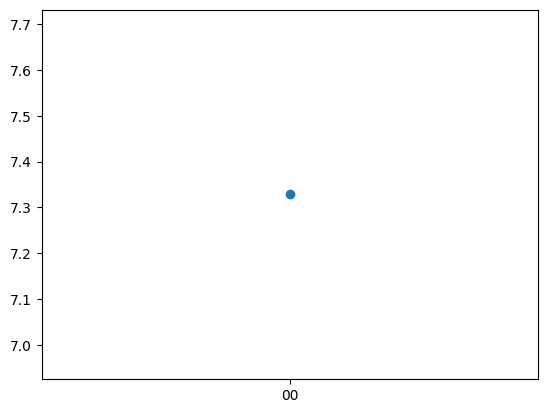

In [60]:
# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
hours = ['00']
plt.plot(hours, scores, marker='o', label='lstm')
plt.show()

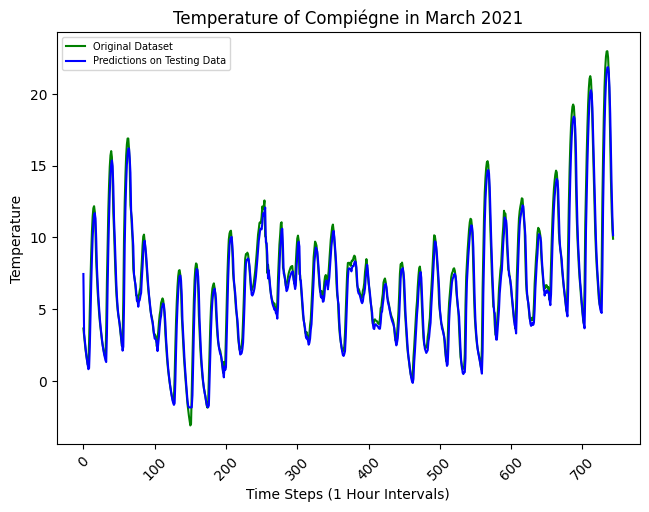

In [61]:
flattened_predictions = predictions.flatten()

# Plot baseline and predictions

plt.plot(df_march_2021['T2m'].values, 'g', label='Original Dataset')
plt.plot(flattened_predictions, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in March 2021')
plt.show()

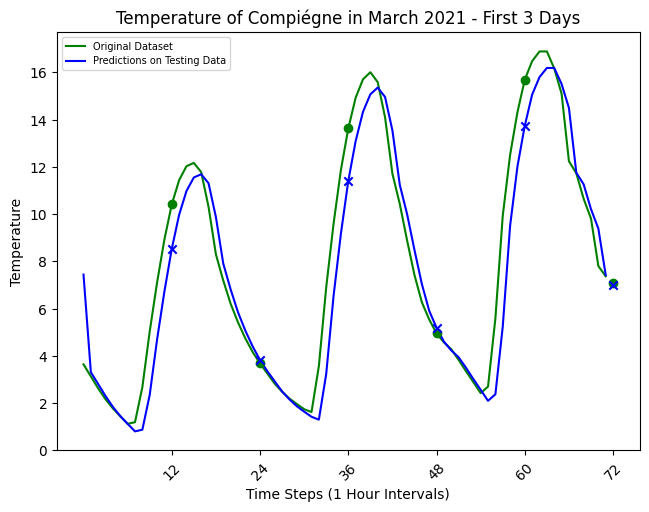

In [62]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(df_march_2021['T2m'].values[:72], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:72], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [12, 24, 36, 48, 60, 72]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = df_march_2021['T2m'].values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in March 2021 - First 3 Days')
plt.show()

# LSTM With Dynamically Adjusted Time Intervals

In [149]:
# Preparing dataset for LSTM training with dynamic time intervals

df_lstm_training = df_jan_feb_2021.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = df_march_2021.values
df_lstm_testing = df_lstm_testing.astype('float32')
test_dynamic = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

n_input = 24
n_output = 24
train, test = reframe_datasets(df_lstm_training, df_lstm_testing, n_input)

In [64]:
model_dynamic = build_model(train, n_input, n_output)

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1369/1369 - 31s - 23ms/step - loss: 0.0193
Epoch 2/100
1369/1369 - 25s - 18ms/step - loss: 0.0144
Epoch 3/100
1369/1369 - 25s - 18ms/step - loss: 0.0140
Epoch 4/100
1369/1369 - 25s - 18ms/step - loss: 0.0137
Epoch 5/100
1369/1369 - 24s - 18ms/step - loss: 0.0134
Epoch 6/100
1369/1369 - 24s - 18ms/step - loss: 0.0130
Epoch 7/100
1369/1369 - 25s - 18ms/step - loss: 0.0123
Epoch 8/100
1369/1369 - 25s - 18ms/step - loss: 0.0118
Epoch 9/100
1369/1369 - 24s - 18ms/step - loss: 0.0114
Epoch 10/100
1369/1369 - 25s - 18ms/step - loss: 0.0107
Epoch 11/100
1369/1369 - 25s - 18ms/step - loss: 0.0101
Epoch 12/100
1369/1369 - 25s - 18ms/step - loss: 0.0096
Epoch 13/100
1369/1369 - 25s - 18ms/step - loss: 0.0094
Epoch 14/100
1369/1369 - 25s - 18ms/step - loss: 0.0092
Epoch 15/100
1369/1369 - 25s - 18ms/step - loss: 0.0090
Epoch 16/100
1369/1369 - 25s - 18ms/step - loss: 0.0088
Epoch 17/100
1369/1369 - 25s - 18ms/step - loss: 0.0087
Epoch 18/100
1369/1369 - 25s - 18ms/step - loss: 0.0086
E

In [150]:
def forecast_dynamic(model, history, n_input, interval_count):
	# flatten data
	data = array(history)
	# data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]

	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0][interval_count-1:interval_count]
	return yhat

In [151]:
# evaluate a single model
def evaluate_model_dynamic(model, train, test, test_dynamic, n_input):

	dynamic_values = list()
	dynamic_count = 0
	k = 0

	while (k <= len(test_dynamic)):
		if dynamic_count <= 24:
			dynamic_values.append(test_dynamic[k:k+1])
			k += 1
		elif dynamic_count <= (24 + 28):
			dynamic_values.append(test_dynamic[k:k+1])
			k += 6
		else:
			dynamic_values.append(test_dynamic[k:k+1])
			k += 12
		dynamic_count += 1

	dynamic_values = array(dynamic_values)
	dynamic_values = dynamic_values.astype('float32')
	dynamic_values = dynamic_values.reshape((dynamic_values.shape[0]*dynamic_values.shape[1], dynamic_values.shape[2]))
	scaler_dynamic = MinMaxScaler(feature_range=(0, 1))
	test_dynamic = scaler_dynamic.fit_transform(dynamic_values)

	# history is a list of daily data
	history = [x for x in train]

	history = np.array(history)

	history = history.reshape((history.shape[0]*history.shape[1], history.shape[2]))

	# Reshape `test` before inverse transform
	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = test.reshape(n_samples * n_timesteps, n_features)

	# walk-forward validation over each day
	predictions = list()

	i = 0
	interval_count = 0
	prediction_count = 0 # To track how many predictions we have made

	while (i <= len(test_reshaped)):

		# Determine n_output dynamically
		if (prediction_count <= 24):
			interval_count = 1  # Hourly predictions
		elif (prediction_count <= (24 + 28)):
			interval_count = 6  # Every 6 hours
		else:
			interval_count = 12  # Every 12 hours

		# predict the day
		yhat_sequence = forecast_dynamic(model, history, n_input, interval_count)

		# store the predictions
		predictions.append(yhat_sequence)

		# get real observation and add to history for predicting the next day
		history = np.append(history, test_reshaped[i:i+interval_count,:], axis=0)

		# Calculate completion percentage
		# completion_rate = (i + 1) / len(test_reshaped) * 100

		# Print progress on the same line
		# print(f'\r{completion_rate:.0f}% complete', end='', flush=True)

		i += interval_count
		prediction_count += 1

	predictions = np.asarray(predictions, dtype="object")

	# evaluate predictions hours for each day
	predictions = array(predictions)

	# Reshape `predictions` before inverse transform
	n_samples = predictions.shape
	predictions_reshaped = predictions.reshape(n_samples[0] * 1, 1)
	
    # Create a scaler for the target feature only
	target_scaler = MinMaxScaler(feature_range=(0, 1))
	
    # Initialize its internal parameters using the ones from the full scaler
	# The scaler must belong to the targeted feature's column
	target_scaler.min_ = scaler_dynamic.min_[0].reshape(1,)
	target_scaler.scale_ = scaler_dynamic.scale_[0].reshape(1,)
	target_scaler.data_min_ = scaler_dynamic.data_min_[0].reshape(1,)
	target_scaler.data_max_ = scaler_dynamic.data_max_[0].reshape(1,)
	target_scaler.data_range_ = scaler_dynamic.data_range_[0].reshape(1,)

	predictions_reshaped = target_scaler.inverse_transform(predictions_reshaped)
	predictions = predictions_reshaped.reshape(n_samples[0], 1, 1)

	n_samples, n_timesteps = test_dynamic.shape
	test_reshaped = scaler_dynamic.inverse_transform(test_dynamic)
		
	test = test_reshaped.reshape(n_samples, n_timesteps, 1)

	return predictions, test

In [152]:
# Evaluate model and get scores
predictions_dynamic, dynamic_testing = evaluate_model_dynamic(model_dynamic, train, test, test_dynamic, n_input)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_18104\3089700234.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_dates = pd.date_range(start=start_date, periods=24, freq='H')  # First 24 points (hourly)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_18104\3089700234.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=6), periods=28, freq='6H')  # Next 28 points (6-hour)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_18104\3089700234.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=1), periods=len(predictions_dynamic)-52, freq='12H')  # Remaining points (daily)


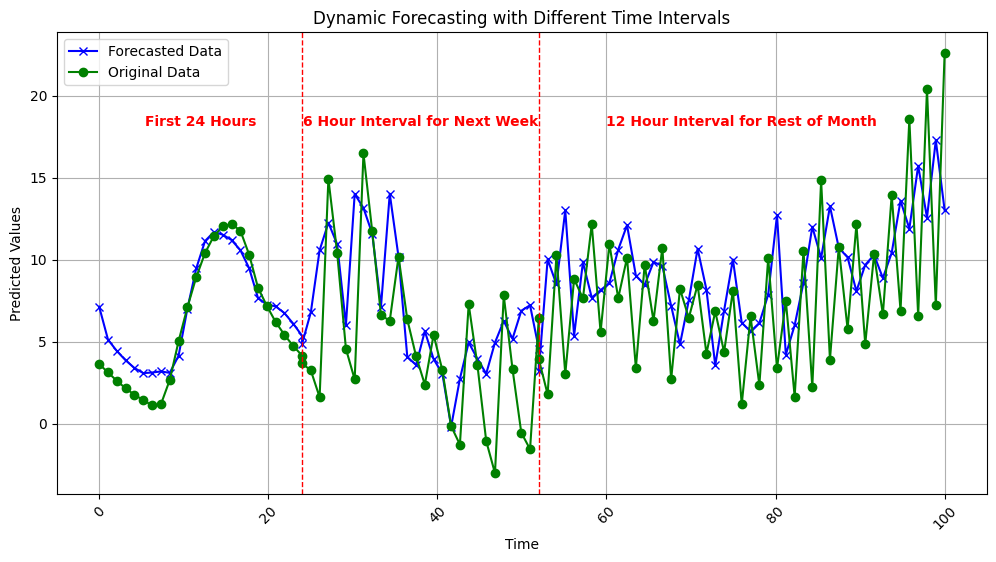

In [179]:
flattened_predictions = predictions_dynamic.flatten()
flattened_test = dynamic_testing.flatten()

# Assume `start_date` is the first timestamp of your forecast
start_date = pd.Timestamp("2023-03-01 00:10")

# Generate corresponding time index
hourly_dates = pd.date_range(start=start_date, periods=24, freq='H')  # First 24 points (hourly)
six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=6), periods=28, freq='6H')  # Next 28 points (6-hour)
daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=1), periods=len(predictions_dynamic)-52, freq='12H')  # Remaining points (daily)

# Combine all time indexes
time_index = hourly_dates.append(six_hour_dates).append(daily_dates)

# Manually create a modified x-axis index for readability
x_ticks = np.concatenate([
    np.linspace(0, 24, len(hourly_dates)), 
    np.linspace(24, 52, len(six_hour_dates)), 
    np.linspace(52, 100, len(daily_dates))  
])

# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(x_ticks, flattened_predictions, marker='x', linestyle='-', color='b', label="Forecasted Data")
plt.plot(x_ticks, flattened_test, marker='o', linestyle='-', color='g', label="Original Data")

# Formatting the x-axis
plt.xlabel("Time")
plt.ylabel("Predicted Values")
plt.title("Dynamic Forecasting with Different Time Intervals")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.grid()

# **Draw vertical lines to separate the intervals**
plt.axvline(x=x_ticks[len(hourly_dates)-1], color='r', linestyle='--', linewidth=1)  # End of hourly interval
plt.axvline(x=x_ticks[len(hourly_dates) + len(six_hour_dates)-1], color='r', linestyle='--', linewidth=1)  # End of 6-hour interval

# **Calculate midpoints for centered text annotations**
mid_hourly = (x_ticks[0] + x_ticks[len(hourly_dates)-1]) / 2
mid_six_hour = (x_ticks[len(hourly_dates)] + x_ticks[len(hourly_dates) + len(six_hour_dates)-1]) / 2
mid_daily = (x_ticks[len(hourly_dates) + len(six_hour_dates)] + x_ticks[-1]) / 2

# **Add text annotations at the center of each interval in bold**
plt.text(mid_hourly, max(flattened_predictions) * 1.05, "First 24 Hours", 
         ha='center', fontsize=10, color='r', fontweight='bold')
plt.text(mid_six_hour, max(flattened_predictions) * 1.05, "6 Hour Interval for Next Week", 
         ha='center', fontsize=10, color='r', fontweight='bold')
plt.text(mid_daily, max(flattened_predictions) * 1.05, "12 Hour Interval for Rest of Month", 
         ha='center', fontsize=10, color='r', fontweight='bold')

# Show the plot
plt.show()

Average RMSE: 3.1963


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_18104\2821451550.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_dates = pd.date_range(start=start_date, periods=24, freq='H')  # First 24 points (hourly)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_18104\2821451550.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=6), periods=28, freq='6H')  # Next 28 points (6-hour)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_18104\2821451550.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=1), periods=len(predictions_dynamic)-52, freq='12H')  # Remaining points (daily)


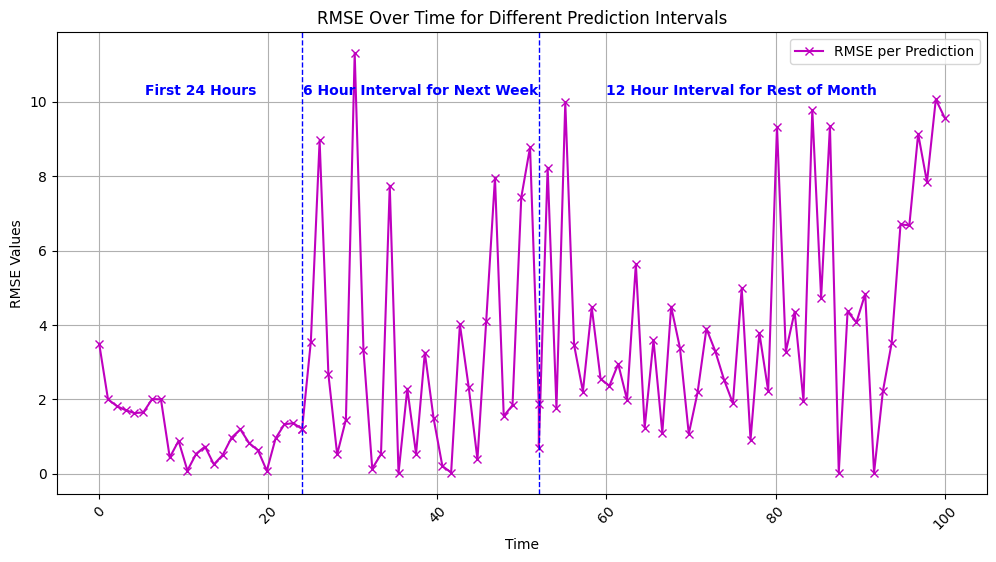

In [180]:
# Compute RMSE for each point
rmse_values = np.sqrt((flattened_predictions - flattened_test) ** 2)

# Compute average RMSE
average_rmse = np.mean(rmse_values)
print(f'Average RMSE: {average_rmse:.4f}')

# Generate custom x-axis spacing
hourly_dates = pd.date_range(start=start_date, periods=24, freq='H')  # First 24 points (hourly)
six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=6), periods=28, freq='6H')  # Next 28 points (6-hour)
daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=1), periods=len(predictions_dynamic)-52, freq='12H')  # Remaining points (daily)

# Combine all time indexes
time_index = hourly_dates.append(six_hour_dates).append(daily_dates)

# Manually create a modified x-axis index for readability
x_ticks = np.concatenate([
    np.linspace(0, 24, len(hourly_dates)), 
    np.linspace(24, 52, len(six_hour_dates)), 
    np.linspace(52, 100, len(daily_dates))  
])

# Plot RMSE values
plt.figure(figsize=(12, 6))
plt.plot(x_ticks, rmse_values, marker='x', linestyle='-', color='m', label="RMSE per Prediction")

# Formatting the x-axis
plt.xlabel("Time")
plt.ylabel("RMSE Values")
plt.title("RMSE Over Time for Different Prediction Intervals")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.grid()

# Draw vertical dashed lines for intervals
plt.axvline(x=x_ticks[len(hourly_dates)-1], color='b', linestyle='--', linewidth=1)  # End of hourly interval
plt.axvline(x=x_ticks[len(hourly_dates) + len(six_hour_dates)-1], color='b', linestyle='--', linewidth=1)  # End of 6-hour interval

# Calculate midpoints for centered text annotations
mid_hourly = (x_ticks[0] + x_ticks[len(hourly_dates)-1]) / 2
mid_six_hour = (x_ticks[len(hourly_dates)] + x_ticks[len(hourly_dates) + len(six_hour_dates)-1]) / 2
mid_daily = (x_ticks[len(hourly_dates) + len(six_hour_dates)] + x_ticks[-1]) / 2

# Add interval text annotations
plt.text(mid_hourly, max(rmse_values) * 0.90, "First 24 Hours", 
         ha='center', fontsize=10, color='b', fontweight='bold')
plt.text(mid_six_hour, max(rmse_values) * 0.90, "6 Hour Interval for Next Week", 
         ha='center', fontsize=10, color='b', fontweight='bold')
plt.text(mid_daily, max(rmse_values) * 0.90, "12 Hour Interval for Rest of Month", 
         ha='center', fontsize=10, color='b', fontweight='bold')

# Show the RMSE plot
plt.show()

# Notes
Encoder-Decoder LSTM With 150 Units, 100 epochs, 1 batch size, relu with look_back = 1 and output = 1 --> 14.38 minutes and 1.052 average RMSE <br>
Encoder-Decoder LSTM With 150 Units, 100 epochs, 1 batch size, relu with look_back = 2 and output = 2 --> 17.24 minutes and 0.973 average RMSE <br>

[7.588] 7.6, 7.6
[7.525] 7.5, 7.5

# Training the Model (ARIMA)

In [138]:
# Preparing dataset for LSTM training

df_lstm_training = df_jan_feb_2021.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = df_march_2021.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

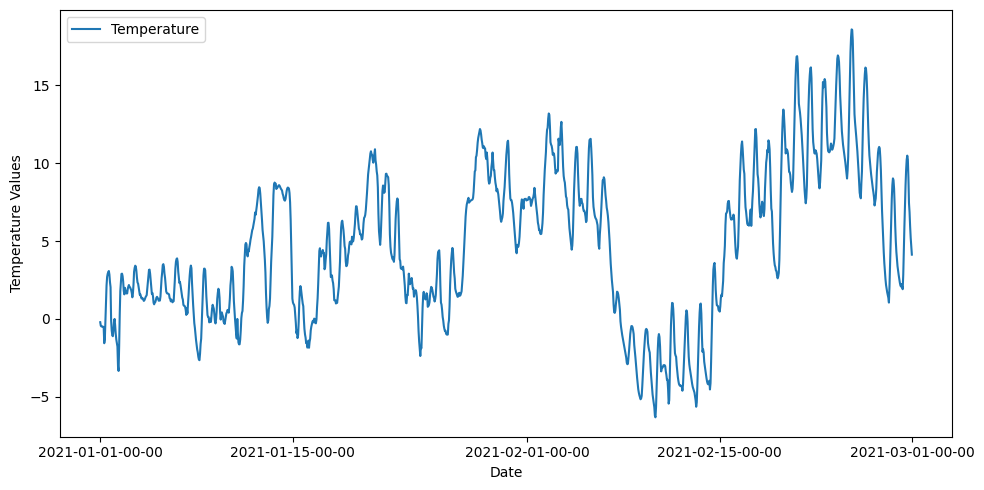

In [139]:
plt.figure(figsize=(10, 5))

plt.plot(df_jan_feb_2021, label='Temperature')

# Set major x-axis locator to show only 4 dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=4))  # Force 4 labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H-%M'))  # Format as 'YYYY-MM-DD-HH-mm'
plt.xlabel("Date")
plt.ylabel("Temperature Values")
plt.legend()
plt.tight_layout()
plt.show()

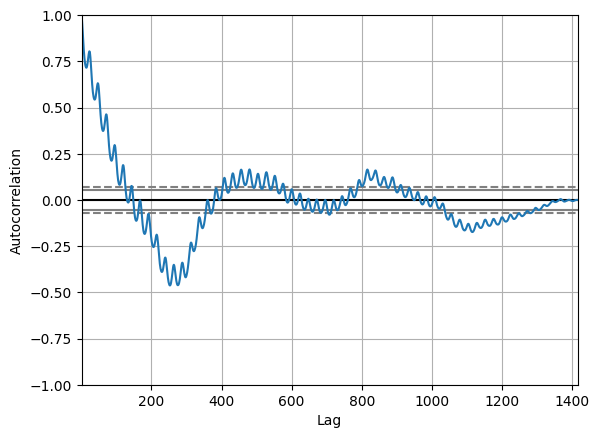

In [140]:
autocorrelation_plot(df_jan_feb_2021)
plt.show()

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    T2m   No. Observations:                 1416
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -637.976
Date:                Wed, 05 Mar 2025   AIC                           1281.953
Time:                        15:17:01   BIC                           1297.717
Sample:                    01-01-2021   HQIC                          1287.843
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9000      0.017     53.100      0.000       0.867       0.933
ar.L2         -0.1624      0.021     -7.884      0.000      -0.203      -0.122
sigma2         0.1442      0.003     42.687      0.0

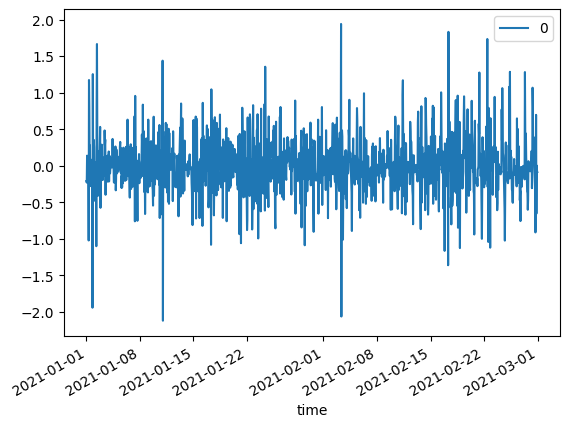

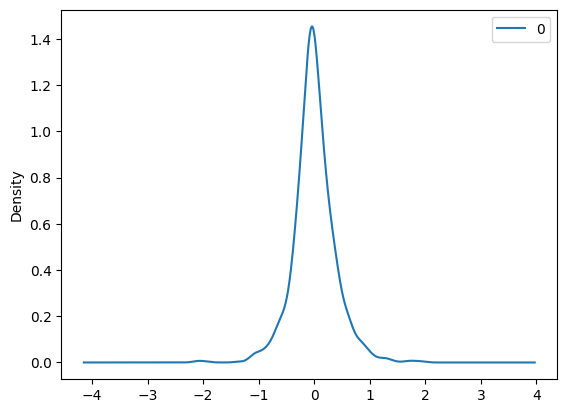

                 0
count  1416.000000
mean      0.000447
std       0.379756
min      -2.119416
25%      -0.192418
50%      -0.022241
75%       0.185718
max       1.939260


In [141]:
# fit model
model_arima = ARIMA(df_jan_feb_2021, order=(2,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

The optimal ARIMA implementation without batch_size optimization:

In [133]:
# Number of timesteps to forecast ahead
n_forecast = 2
n_steps = 2

# Split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = []
rmse_per_prediction = []  # Store RMSE per prediction

# Fit the initial ARIMA model only once
model_arima = ARIMA(history_arima, order=(n_steps,1,0)) 
model_fit = model_arima.fit()

# Walk-forward validation for multi-step forecasting
t = 0
while t < len(test_arima):

    # Forecast n_forecast steps ahead
    output_arima = model_fit.forecast(steps=n_forecast)
    yhat_arima = output_arima[:n_forecast]  # Get the predicted values

    # Store predictions
    predictions_arima.extend(yhat_arima)

    # Append actual observations to history
    actual_values = test_arima[t:t+n_forecast]  # Get actual values for next n timesteps
    history_arima.extend(actual_values)

    # Update the model with the new history (without refitting)
    model_fit = model_fit.append(actual_values, refit=False)

    # Compute RMSE for these 7 predictions
    multiple_rmse = np.sqrt(np.mean((yhat_arima - actual_values) ** 2))
    rmse_per_prediction.append(multiple_rmse)

    # Update completion percentage
    t += n_forecast  # Move ahead by n_forecast steps
    completion_rate = (t / len(test_arima)) * 100
    
    print(f'Predicted {n_forecast} steps ahead | RMSE={multiple_rmse:.6f} | {completion_rate:.0f}% complete')


Predicted 2 steps ahead | RMSE=0.151901 | 0% complete
Predicted 2 steps ahead | RMSE=0.043479 | 1% complete
Predicted 2 steps ahead | RMSE=0.008757 | 1% complete
Predicted 2 steps ahead | RMSE=0.003452 | 1% complete
Predicted 2 steps ahead | RMSE=0.105892 | 1% complete
Predicted 2 steps ahead | RMSE=0.046379 | 2% complete
Predicted 2 steps ahead | RMSE=0.027598 | 2% complete
Predicted 2 steps ahead | RMSE=0.013246 | 2% complete
Predicted 2 steps ahead | RMSE=0.052529 | 2% complete
Predicted 2 steps ahead | RMSE=0.042708 | 3% complete
Predicted 2 steps ahead | RMSE=0.025441 | 3% complete
Predicted 2 steps ahead | RMSE=0.015919 | 3% complete
Predicted 2 steps ahead | RMSE=0.011260 | 3% complete
Predicted 2 steps ahead | RMSE=0.010463 | 4% complete
Predicted 2 steps ahead | RMSE=0.006356 | 4% complete
Predicted 2 steps ahead | RMSE=0.003999 | 4% complete
Predicted 2 steps ahead | RMSE=0.156063 | 5% complete
Predicted 2 steps ahead | RMSE=0.057125 | 5% complete
Predicted 2 steps ahead | RM

The optimal ARIMA implementation with batch_size optimization:

In [142]:
# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_forecast = 2
n_steps = 2
percentage = 0

# walk-forward validation
while check:

	model_arima = ARIMA(history_arima, order=(n_steps,1,0))
	model_fit = model_arima.fit()
	
	# Forecast n_forecast steps ahead
	output_arima = model_fit.forecast(steps=n_forecast)
	yhat_arima = output_arima[:n_forecast]  # Get the predicted values

	# Store predictions
	predictions_arima.extend(yhat_arima)

	# Append actual observations to history
	actual_values = test_arima[percentage:percentage+n_forecast]  # Get actual values for next n timesteps
	history_arima.extend(actual_values)

	# Update the model with the new history (without refitting)
	model_fit = model_fit.append(actual_values, refit=False)

	# Compute RMSE for these 7 predictions
	multiple_rmse = np.sqrt(np.mean((yhat_arima - actual_values) ** 2))
	rmse_per_prediction.append(multiple_rmse)

	# Update completion percentage
	percentage += n_forecast  # Move ahead by n_forecast steps
	completion_rate = (percentage / len(test_arima)) * 100
	
	print(f'Predicted {n_forecast} steps ahead | RMSE={multiple_rmse:.6f} | {completion_rate:.0f}% complete')
	
	if (percentage >= len(test_arima)):
		check = False

Predicted 2 steps ahead | RMSE=0.151901 | 0% complete
Predicted 2 steps ahead | RMSE=0.035294 | 1% complete
Predicted 2 steps ahead | RMSE=0.008771 | 1% complete
Predicted 2 steps ahead | RMSE=0.003541 | 1% complete
Predicted 2 steps ahead | RMSE=0.106886 | 1% complete
Predicted 2 steps ahead | RMSE=0.047031 | 2% complete
Predicted 2 steps ahead | RMSE=0.027665 | 2% complete
Predicted 2 steps ahead | RMSE=0.014420 | 2% complete
Predicted 2 steps ahead | RMSE=0.053451 | 2% complete
Predicted 2 steps ahead | RMSE=0.044392 | 3% complete
Predicted 2 steps ahead | RMSE=0.024357 | 3% complete
Predicted 2 steps ahead | RMSE=0.015784 | 3% complete
Predicted 2 steps ahead | RMSE=0.011210 | 3% complete
Predicted 2 steps ahead | RMSE=0.010406 | 4% complete
Predicted 2 steps ahead | RMSE=0.006294 | 4% complete
Predicted 2 steps ahead | RMSE=0.003945 | 4% complete
Predicted 2 steps ahead | RMSE=0.156276 | 5% complete
Predicted 2 steps ahead | RMSE=0.057210 | 5% complete
Predicted 2 steps ahead | RM

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted 2 steps ahead | RMSE=0.085068 | 37% complete
Predicted 2 steps ahead | RMSE=0.027910 | 37% complete
Predicted 2 steps ahead | RMSE=0.018649 | 37% complete
Predicted 2 steps ahead | RMSE=0.060093 | 38% complete
Predicted 2 steps ahead | RMSE=0.020785 | 38% complete
Predicted 2 steps ahead | RMSE=0.023820 | 38% complete
Predicted 2 steps ahead | RMSE=0.008302 | 38% complete
Predicted 2 steps ahead | RMSE=0.010154 | 39% complete
Predicted 2 steps ahead | RMSE=0.004858 | 39% complete
Predicted 2 steps ahead | RMSE=0.003739 | 39% complete
Predicted 2 steps ahead | RMSE=0.004529 | 40% complete
Predicted 2 steps ahead | RMSE=0.031204 | 40% complete
Predicted 2 steps ahead | RMSE=0.008361 | 40% complete
Predicted 2 steps ahead | RMSE=0.052620 | 40% complete
Predicted 2 steps ahead | RMSE=0.010092 | 41% complete
Predicted 2 steps ahead | RMSE=0.077262 | 41% complete
Predicted 2 steps ahead | RMSE=0.094061 | 41% complete
Predicted 2 steps ahead | RMSE=0.019125 | 41% complete
Predicted 

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted 2 steps ahead | RMSE=0.130798 | 72% complete
Predicted 2 steps ahead | RMSE=0.027991 | 73% complete
Predicted 2 steps ahead | RMSE=0.018196 | 73% complete
Predicted 2 steps ahead | RMSE=0.009397 | 73% complete
Predicted 2 steps ahead | RMSE=0.020525 | 73% complete
Predicted 2 steps ahead | RMSE=0.069326 | 74% complete
Predicted 2 steps ahead | RMSE=0.037998 | 74% complete
Predicted 2 steps ahead | RMSE=0.019134 | 74% complete
Predicted 2 steps ahead | RMSE=0.009053 | 74% complete
Predicted 2 steps ahead | RMSE=0.006228 | 75% complete
Predicted 2 steps ahead | RMSE=0.010013 | 75% complete
Predicted 2 steps ahead | RMSE=0.042414 | 75% complete
Predicted 2 steps ahead | RMSE=0.146403 | 76% complete
Predicted 2 steps ahead | RMSE=0.048038 | 76% complete
Predicted 2 steps ahead | RMSE=0.022808 | 76% complete
Predicted 2 steps ahead | RMSE=0.010648 | 76% complete
Predicted 2 steps ahead | RMSE=0.036104 | 77% complete
Predicted 2 steps ahead | RMSE=0.069988 | 77% complete
Predicted 

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted 2 steps ahead | RMSE=0.048088 | 87% complete
Predicted 2 steps ahead | RMSE=0.016913 | 87% complete


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted 2 steps ahead | RMSE=0.012250 | 87% complete
Predicted 2 steps ahead | RMSE=0.016769 | 87% complete
Predicted 2 steps ahead | RMSE=0.013643 | 88% complete
Predicted 2 steps ahead | RMSE=0.011087 | 88% complete
Predicted 2 steps ahead | RMSE=0.031620 | 88% complete
Predicted 2 steps ahead | RMSE=0.072249 | 88% complete


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted 2 steps ahead | RMSE=0.032370 | 89% complete
Predicted 2 steps ahead | RMSE=0.016269 | 89% complete
Predicted 2 steps ahead | RMSE=0.007505 | 89% complete
Predicted 2 steps ahead | RMSE=0.028942 | 90% complete


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted 2 steps ahead | RMSE=0.080551 | 90% complete
Predicted 2 steps ahead | RMSE=0.042935 | 90% complete
Predicted 2 steps ahead | RMSE=0.020626 | 90% complete
Predicted 2 steps ahead | RMSE=0.013953 | 91% complete
Predicted 2 steps ahead | RMSE=0.011090 | 91% complete
Predicted 2 steps ahead | RMSE=0.013647 | 91% complete
Predicted 2 steps ahead | RMSE=0.053774 | 91% complete
Predicted 2 steps ahead | RMSE=0.101950 | 92% complete
Predicted 2 steps ahead | RMSE=0.047314 | 92% complete
Predicted 2 steps ahead | RMSE=0.023643 | 92% complete
Predicted 2 steps ahead | RMSE=0.010715 | 92% complete
Predicted 2 steps ahead | RMSE=0.028832 | 93% complete
Predicted 2 steps ahead | RMSE=0.105986 | 93% complete
Predicted 2 steps ahead | RMSE=0.047185 | 93% complete
Predicted 2 steps ahead | RMSE=0.022996 | 94% complete
Predicted 2 steps ahead | RMSE=0.015445 | 94% complete
Predicted 2 steps ahead | RMSE=0.022905 | 94% complete
Predicted 2 steps ahead | RMSE=0.012442 | 94% complete
Predicted 

In [143]:
# evaluate predictions hours for each day
predictions_arima = array(predictions_arima)

# Reshape `predictions` before inverse transform
n_samples = predictions_arima.shape
predictions_arima_rs = predictions_arima.reshape(n_samples[0], 1)

# Create a scaler for the target feature only
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize its internal parameters using the ones from the full scaler
# The scaler must belong to the targeted feature's column
target_scaler.min_ = scaler.min_[0].reshape(1,)
target_scaler.scale_ = scaler.scale_[0].reshape(1,)
target_scaler.data_min_ = scaler.data_min_[0].reshape(1,)
target_scaler.data_max_ = scaler.data_max_[0].reshape(1,)
target_scaler.data_range_ = scaler.data_range_[0].reshape(1,)

predictions_arima_tf = target_scaler.inverse_transform(predictions_arima_rs)

test_reshaped = scaler.inverse_transform(test_arima)

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_reshaped, predictions_arima_tf))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.956


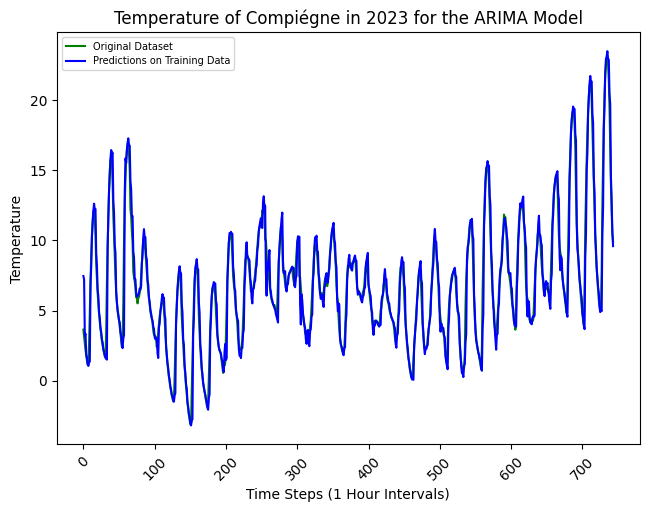

In [144]:
# Plot baseline and predictions

plt.plot(test_reshaped, 'g', label='Original Dataset')
plt.plot(predictions_arima_tf, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the ARIMA Model')
plt.show()

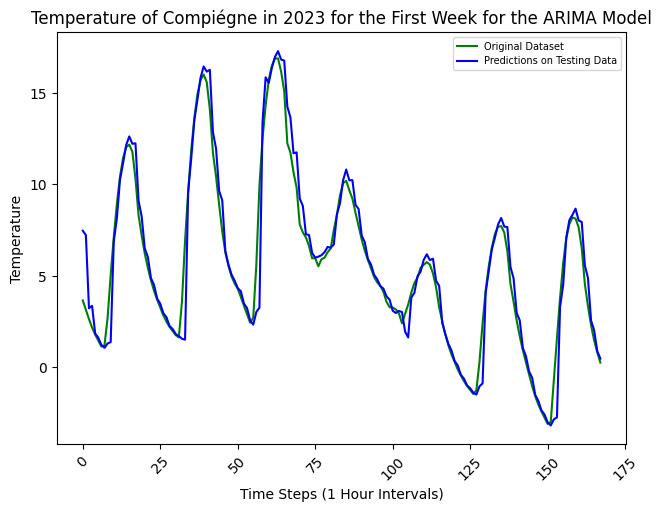

In [145]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(test_reshaped[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(predictions_arima_tf[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week for the ARIMA Model')
plt.show()

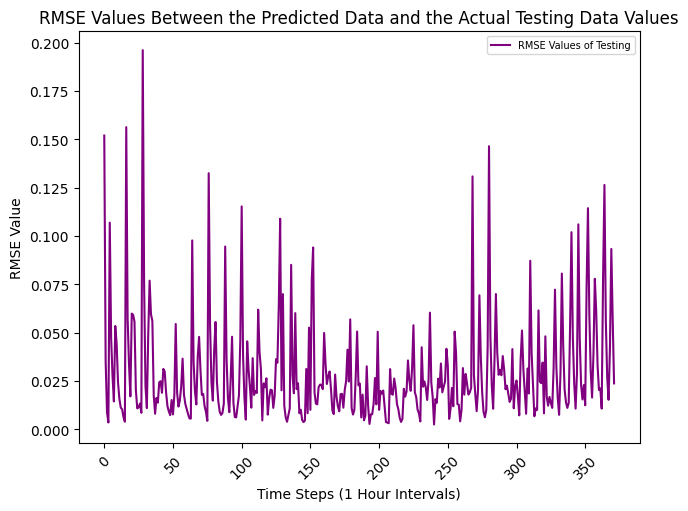

In [146]:
# Creating a graph for the RMSE values

plt.plot(rmse_per_prediction, 'purple', label='RMSE Values of Testing')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

# Shelved Codes

In [ ]:
"""# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_output = 2
percentage = 0

# walk-forward validation
while check:

	model_arima = ARIMA(history_arima, order=(2,1,0))
	model_fit = model_arima.fit()
	
	for t in range(n_output):
		output_arima = model_fit.forecast()
		yhat_arima = output_arima[0]
		predictions_arima.append(yhat_arima)
		obs = test_arima[percentage]
		history_arima.append(obs)

		# Update the model with predicted observation
		model_fit = model_fit.append([yhat_arima], refit=False)

		# Compute RMSE for this single prediction
		single_rmse = np.sqrt((yhat_arima - obs) ** 2)
		rmse_per_prediction.append(single_rmse)

		# Calculate completion percentage
		completion_rate = (percentage + 1) / len(test_arima) * 100
		
		print('predicted=%f, expected=%f, RMSE=%f | %f%% complete' % (yhat_arima, obs, single_rmse, completion_rate))

		percentage += 1
	
	if (percentage == len(test_arima)):
		check = False"""

In [ ]:
"""# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

# Fit the initial ARIMA model only once
model_arima = ARIMA(history_arima, order=(1,1,0))
model_fit = model_arima.fit()

# walk-forward validation
while t in range(len(test_arima)):
	output_arima = model_fit.forecast()
	yhat_arima = output_arima[0]
	predictions_arima.append(yhat_arima)
	obs = test_arima[t]
	history_arima.append(obs)

    # Instead of retraining, update the model
	model_fit = model_fit.append([obs], refit=False)

	# Compute RMSE for this single prediction
	single_rmse = np.sqrt((yhat_arima - obs) ** 2)
	rmse_per_prediction.append(single_rmse)

	# Calculate completion percentage
	completion_rate = (t + 1) / len(test_arima) * 100
	
	print('predicted=%f, expected=%f, RMSE=%f | %f%% complete' % (yhat_arima, obs, single_rmse, completion_rate))"""

In [ ]:
"""predictions_first = predictions[:,:,:1]
predictions_second = predictions[:,:,1:2]"""

'predictions_first = predictions[:,:,:1]\npredictions_second = predictions[:,:,1:2]'

In [ ]:
"""flattened_predictions_first = predictions_first.flatten()
flattened_predictions_second = predictions_second.flatten()"""

'flattened_predictions_first = predictions_first.flatten()\nflattened_predictions_second = predictions_second.flatten()'

In [ ]:
"""# Plot baseline and predictions

plt.plot(df_march_2021['T2m'].values, 'g', label='Original Dataset')
plt.plot(flattened_predictions_first, 'b', label='Predictions on Testing Data 1')
plt.plot(flattened_predictions_second, 'r', label='Predictions on Testing Data 2')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in March 2021')
plt.show()"""

"# Plot baseline and predictions\n\nplt.plot(df_march_2021['T2m'].values, 'g', label='Original Dataset')\nplt.plot(flattened_predictions_first, 'b', label='Predictions on Testing Data 1')\nplt.plot(flattened_predictions_second, 'r', label='Predictions on Testing Data 2')\nplt.legend(fontsize=7)\n\nplt.xticks(rotation=45)  # Rotate x-axis labels for clarity\nplt.tight_layout()  # Adjust layout to prevent clipping\nplt.xlabel('Time Steps (1 Hour Intervals)')\nplt.ylabel('Temperature')\nplt.title('Temperature of Compiégne in March 2021')\nplt.show()"

In [ ]:
"""
# Plot baseline and predictions for the first 168 timesteps
plt.plot(df_march_2021['T2m'].values[:72], 'g', label='Original Dataset')  # Slice the first 72 timesteps
plt.plot(flattened_predictions_first[:72], 'b', label='Predictions on Testing Data 1')  # Slice the first 72 timesteps
plt.plot(flattened_predictions_second[:72], 'r', label='Predictions on Testing Data 2')  # Slice the first 72 timesteps

# Define the tick positions and labels
tick_positions = [12, 24, 36, 48, 60, 72]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = df_march_2021['T2m'].values[tick_positions]
predicted_y_values = flattened_predictions_first[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in March 2021 - First 3 Days')
plt.show()
"""

"\n# Plot baseline and predictions for the first 168 timesteps\nplt.plot(df_march_2021['T2m'].values[:72], 'g', label='Original Dataset')  # Slice the first 72 timesteps\nplt.plot(flattened_predictions_first[:72], 'b', label='Predictions on Testing Data 1')  # Slice the first 72 timesteps\nplt.plot(flattened_predictions_second[:72], 'r', label='Predictions on Testing Data 2')  # Slice the first 72 timesteps\n\n# Define the tick positions and labels\ntick_positions = [12, 24, 36, 48, 60, 72]\ntick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling\n\n# Get the y-values corresponding to the x-tick positions\noriginal_y_values = df_march_2021['T2m'].values[tick_positions]\npredicted_y_values = flattened_predictions_first[tick_positions]\n\n# Add pins (markers) at xtick locations\nplt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)\nplt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)\n\n# Customize 